Loading manifest from ../data/d2_manifest_t2fs.csv and creating slice map...
Slice map created. Found 582 slices containing the uterus.
Data successfully split:
Training patients: 48, Validation patients: 12
Training slices: 450
Validation slices: 132

Using device: cpu

--- Starting Attention U-Net Model Training (Expanded Dataset) ---


Validation: 100%|██████████| 9/9 [02:00<00:00, 13.41s/it]


Epoch 1/5 -> Train Loss: 0.6808, Val Loss: 0.8538, Val Dice: 0.1062


Validation: 100%|██████████| 9/9 [02:12<00:00, 14.77s/it]


Epoch 2/5 -> Train Loss: 0.5834, Val Loss: 0.5939, Val Dice: 0.5838


Validation: 100%|██████████| 9/9 [01:51<00:00, 12.38s/it]


Epoch 3/5 -> Train Loss: 0.5537, Val Loss: 0.6157, Val Dice: 0.4901


Validation: 100%|██████████| 9/9 [01:49<00:00, 12.16s/it]


Epoch 4/5 -> Train Loss: 0.5397, Val Loss: 0.5385, Val Dice: 0.6782


Validation: 100%|██████████| 9/9 [01:45<00:00, 11.67s/it]


Epoch 5/5 -> Train Loss: 0.5221, Val Loss: 0.5315, Val Dice: 0.6324
--- Finished Training ---


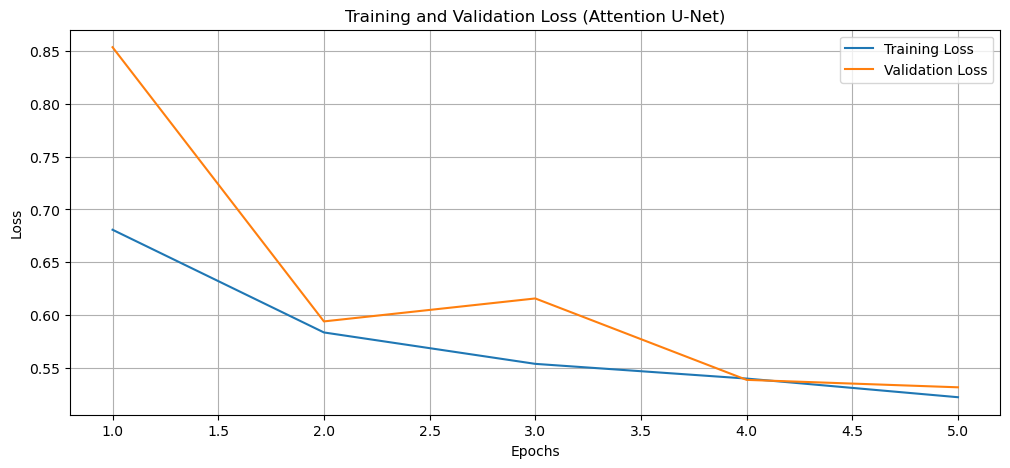

In [3]:
# --- Imports ---
import sys
import os
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import SimpleITK as sitk

# Import our custom classes from the src directory
from src.data_loader import UterusDataset
from src.models import AttentionUNet

# --- Configuration ---
manifest_path = '../data/d2_manifest_t2fs.csv'
image_size = 256
batch_size = 16
num_epochs = 5
lr = 1e-4

# --- Data Loading and Splitting (FINAL CORRECTED VERSION) ---
full_dataset = UterusDataset(manifest_path=manifest_path, image_size=image_size)

# 1. Get the definitive list of patients who have usable data
loaded_manifest = full_dataset.manifest
used_patient_indices = sorted(list(set([sm['patient_index'] for sm in full_dataset.slice_map])))
usable_patient_ids = loaded_manifest.iloc[used_patient_indices]['patient_id'].unique()

# 2. Split this list of usable patients into training and validation sets (80/20 split)
split_idx = int(len(usable_patient_ids) * 0.8)
train_ids = usable_patient_ids[:split_idx]
val_ids = usable_patient_ids[split_idx:]

# 3. Create the final indices for our subsets
train_indices = [i for i, sm in enumerate(full_dataset.slice_map) if full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in train_ids]
val_indices = [i for i, sm in enumerate(full_dataset.slice_map) if full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in val_ids]

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Data successfully split:")
print(f"Training patients: {len(train_ids)}, Validation patients: {len(val_ids)}")
print(f"Training slices: {len(train_dataset)}")
print(f"Validation slices: {len(val_dataset)}")

# --- Metrics and Loss Function ---
def dice_score(preds, targets, epsilon=1e-6):
    preds_flat = preds.view(-1); targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2. * intersection + epsilon) / (preds_flat.sum() + targets_flat.sum() + epsilon)

class DiceBCELoss(nn.Module):
    def __init__(self, weight=0.5): super(DiceBCELoss, self).__init__(); self.weight = weight
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs); inputs_flat = inputs.view(-1); targets_flat = targets.view(-1)
        bce = F.binary_cross_entropy(inputs_flat, targets_flat, reduction='mean')
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs_flat.sum() + targets_flat.sum() + smooth)
        return bce * self.weight + dice_loss * (1 - self.weight)

# --- Training and Validation Functions ---
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train(); running_loss = 0.0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad(); outputs = model(images); loss = criterion(outputs, masks); loss.backward(); optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval(); running_loss = 0.0; running_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images); loss = criterion(outputs, masks)
            preds = torch.sigmoid(outputs) > 0.5; dice = dice_score(preds, masks)
            running_loss += loss.item() * images.size(0); running_dice += dice.item() * images.size(0)
    return running_loss / len(loader.dataset), running_dice / len(loader.dataset)

# --- Main Training Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"\nUsing device: {device}")

attention_model = AttentionUNet(n_channels=1, n_classes=1).to(device)
optimizer = Adam(attention_model.parameters(), lr=lr)
criterion = DiceBCELoss()

train_loss_history, val_loss_history, val_dice_history = [], [], []

print("\n--- Starting Attention U-Net Model Training (Expanded Dataset) ---")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(attention_model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(attention_model, val_loader, criterion, device)
    train_loss_history.append(train_loss); val_loss_history.append(val_loss); val_dice_history.append(val_dice)
    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
print("--- Finished Training ---")

# --- Visualization ---
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss (Attention U-Net)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()